## Inpost forecasting
Author: Andrii Zapukhlyi

#### Data description: 
- DimDates - CSV file - Database with date information (Year, Month, Day, Weekday, Weekend, Holiday, etc.)
- PostingVolume - Parquet file - Database with daily transmissions (From January 1, 2021 to August 31, 2023). The data is grouped per day by two services APM and COURIER along with a separated customer X. This customer provides us with its order forecast every month at the end of the previous month
- Customers_Orders - EXCEL file - Data provided by customer (X) since the beginning of 2023. The data for the upcoming month is sent at the end of the previous month. The file contains the number of orders expected by the customer each day
- Task_Data_Temperature - Folder with CSV Files - The folder contains CSV files, where each file (for each month - between January 2021 and August 2023) stores data on temperatures (maximum, average, minimum temperature) and precipitation (rain and snow). The data is collected for two cities: Warszaw and Krakow


#### Project objective:
Import, preprocess, analyze the provided datasets and develop predictive models to forecast the number of transmissions for a specific day in the upcoming week or month

## Data and libraries import

In [1]:
from scipy.stats import skew
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
from sklearn.model_selection import cross_val_score


In [2]:
df1 = pd.read_csv("dimDates_Task.csv", sep = ";")
df2 = pd.read_parquet("Posting_Volumes")
df3 = pd.read_excel("X_ClientORDERS.xlsx")
df4 = pd.DataFrame()

I'll use `os` library to merge all CSV files in the folder `Zadanie_Dane_Temperatura` with temperature data into one DataFrame

In [3]:
temp_list = []

for file in os.listdir("Zadanie_Dane_Temperatura"):
    if file.endswith(".csv"):
        temp_df = pd.read_csv(f"Zadanie_Dane_Temperatura/{file}")
        temp_list.append(temp_df)

df4 = pd.concat(temp_list, ignore_index=True)

In [4]:
df1.head()

,datePk,dateId,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,dateMonth,dateDay,dateDaySuffix,...,courierBillingPeriodStartDateFk,courierBillingPeriodEndDateFk,xlsDate,dwhDateFrom,dwhDateTo,dwhCurrRec,dwhAuditCd,dwhAuditCp,dwhAuditMd,dwhAuditMp
0,20201004,2020-10-04,2020,2020,10.202,T40-2020,Q4-2020,10,4,th,...,20201001,20201015,44108,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
1,20200810,2020-08-10,2020,2020,8.202,T33-2020,Q3-2020,8,10,th,...,20200801,20200815,44053,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
2,20200930,2020-09-30,2020,2020,9.202,T40-2020,Q3-2020,9,30,th,...,20200916,20200930,44104,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
3,20200521,2020-05-21,2020,2020,5.202,T21-2020,Q2-2020,5,21,st,...,20200516,20200531,43972,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719
4,20200527,2020-05-27,2020,2020,5.202,T22-2020,Q2-2020,5,27,th,...,20200516,20200531,43978,1900-01-01,9999-12-31,1,2020-07-03 13:51:15.673,1904719,2020-07-03 13:51:15.673,1904719


In [5]:
df2.head()

,postingDateFk,Product,Customer,Volume
0,20210101,APM,X,2401.301452
1,20210102,APM,X,20195.515269
2,20210103,APM,X,63561.702640
3,20210104,APM,X,40310.645622
4,20210105,APM,X,54800.879137


In [6]:
df3.head()

,DateId,Orders
0,20230101,161366.064671
1,20230102,296627.324653
2,20230103,378262.368584
3,20230104,320907.583398
4,20230105,93098.214405


In [7]:
df4.head()

,Nazwa stacji,Rok,Miesiac,Dzien,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,KRAKOW,2021,8,1,23.9,17.3,20.1,5.7,0
1,KRAKOW,2021,8,2,22.8,14.4,17.2,0.5,0
2,KRAKOW,2021,8,3,25.6,11.6,18.3,0.4,0
3,KRAKOW,2021,8,4,24.9,14.3,19.4,5.2,0
4,KRAKOW,2021,8,5,21.5,15.9,17.5,103.4,0


There are 4 datasets with different data, which will be useful for prediction, so I'll join them into one

## Data wrangling

In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DateId  243 non-null    int64  
 1   Orders  242 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


The dataset containing client orders includes a `DateId` column in `int64` format. To convert this column into a datetime format, it is necessary first to convert it to a string representation before performing the datetime conversion

In [9]:
df3["DateId"] = df3["DateId"].astype(str)

The temperature dataset contains separate columns for year, month, and day. I have combined these columns into a single string column formatted as "Year-month-day" to match the date format used in the other datasets

In [10]:
temp_date = []

for i in range(len(df4)):
    rok = df4["Rok"].values[i]
    miesiac = df4["Miesiac"].values[i]
    dzien = df4["Dzien"].values[i]
    temp_date.append(f"{rok}-{miesiac}-{dzien}")
    
df4["date"] = temp_date

In [11]:
df1["date"] = pd.to_datetime(df1["dateId"])
df2["date"] = pd.to_datetime(df2["postingDateFk"])
df3["date"] = pd.to_datetime(df3["DateId"], format="%Y%m%d")
df4["date"] = pd.to_datetime(df4["date"])
df1.drop(["dateId"], axis=1, inplace=True)
df2.drop(["postingDateFk"], axis = 1, inplace = True)
df3.drop(["DateId"], axis= 1, inplace = True)
df4.drop(["Rok", "Miesiac", "Dzien"], axis=1, inplace = True)

Then, I created a `date` feature in each dataset with datetime format and dropped old columns with date

In [12]:
df1.date, df2.date, df3.date, df4.date

(0      2020-10-04
 1      2020-08-10
 2      2020-09-30
 3      2020-05-21
 4      2020-05-27
           ...    
 1456   2020-03-05
 1457   2020-04-17
 1458   2020-11-04
 1459   2020-11-16
 1460   2021-01-17
 Name: date, Length: 1461, dtype: datetime64[ns],
 0      2021-01-01
 1      2021-01-02
 2      2021-01-03
 3      2021-01-04
 4      2021-01-05
           ...    
 3887   2023-08-27
 3888   2023-08-28
 3889   2023-08-29
 3890   2023-08-30
 3891   2023-08-31
 Name: date, Length: 3892, dtype: datetime64[ns],
 0     2023-01-01
 1     2023-01-02
 2     2023-01-03
 3     2023-01-04
 4     2023-01-05
          ...    
 238   2023-08-27
 239   2023-08-28
 240   2023-08-29
 241   2023-08-30
 242   2023-08-31
 Name: date, Length: 243, dtype: datetime64[ns],
 0      2021-08-01
 1      2021-08-02
 2      2021-08-03
 3      2021-08-04
 4      2021-08-05
           ...    
 1941   2022-11-26
 1942   2022-11-27
 1943   2022-11-28
 1944   2022-11-29
 1945   2022-11-30
 Name: date, Length: 1946,

In [13]:
print("Shapes of the data frames:")
print("df1:", df1.shape,
      "\ndf2:", df2.shape,
      "\ndf3:", df3.shape,
      "\ndf4:", df4.shape)

Shapes of the data frames:
df1: (1461, 53) 
df2: (3892, 4) 
df3: (243, 2) 
df4: (1946, 7)


In [14]:
df = df2.merge(df1, left_on="date", right_on = "date", how="left")
df = df.merge(df3, left_on="date", right_on = "date", how="left")
df = df.merge(df4, left_on="date", right_on = "date", how="left")
df.to_csv("data.csv", index=False)
df.sample(5)

,Product,Customer,Volume,date,datePk,dateYear,dateYearISO,dateMonthYear,dateWeekYearISO,dateQuarterYear,...,dwhAuditCp,dwhAuditMd,dwhAuditMp,Orders,Nazwa stacji,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
2476,APM,Rest,208828.051265,2021-09-23,20210923,2021,2021,9.2021,T38-2021,Q3-2021,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,17.1,8.7,12.7,0.8,0
5178,COURIER,X,192993.985630,2022-10-06,20221006,2022,2022,10.2022,T40-2022,Q4-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,KRAKOW,21.5,6.0,12.7,0.0,0
5585,COURIER,X,116233.400905,2023-04-27,20230427,2023,2023,4.2023,T17-2023,Q2-2023,...,1904719,2020-07-03 13:51:15.673,1904719,258434.577665,WARSZAWA,10.7,2.3,6.2,0.0,0
7275,COURIER,Rest,318214.918938,2022-12-20,20221220,2022,2022,12.2022,T51-2022,Q4-2022,...,1904719,2020-07-03 13:51:15.673,1904719,NaN,WARSZAWA,3.7,-5.7,0.2,0.0,0
3554,APM,Rest,197852.978930,2023-03-16,20230316,2023,2023,3.2023,T11-2023,Q1-2023,...,1904719,2020-07-03 13:51:15.673,1904719,252489.527570,KRAKOW,8.1,-2.1,2.3,0.0,0


I combined the datasets using the `merge()` function from pandas, which operates similarly to `SQL JOIN`. <br>
The second DataFrame, which contains the daily postings and includes the target variable, served as the base for merging additional datasets using a left join.

I will remove `[`, `]` and `<` symbols from the column names for the XGBoost regression

In [15]:
df.columns = df.columns.str.replace('[', '', regex=False) \
                       .str.replace(']', '', regex=False) \
                       .str.replace('<', '', regex=False)

In [16]:
datet = df.select_dtypes(include=[np.datetime64]).columns.tolist()
num = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()
categ = [col for col in df.columns if col not in num and col not in datet]

Besides, I created the lists of numerical and category features to make the following analysis easier.

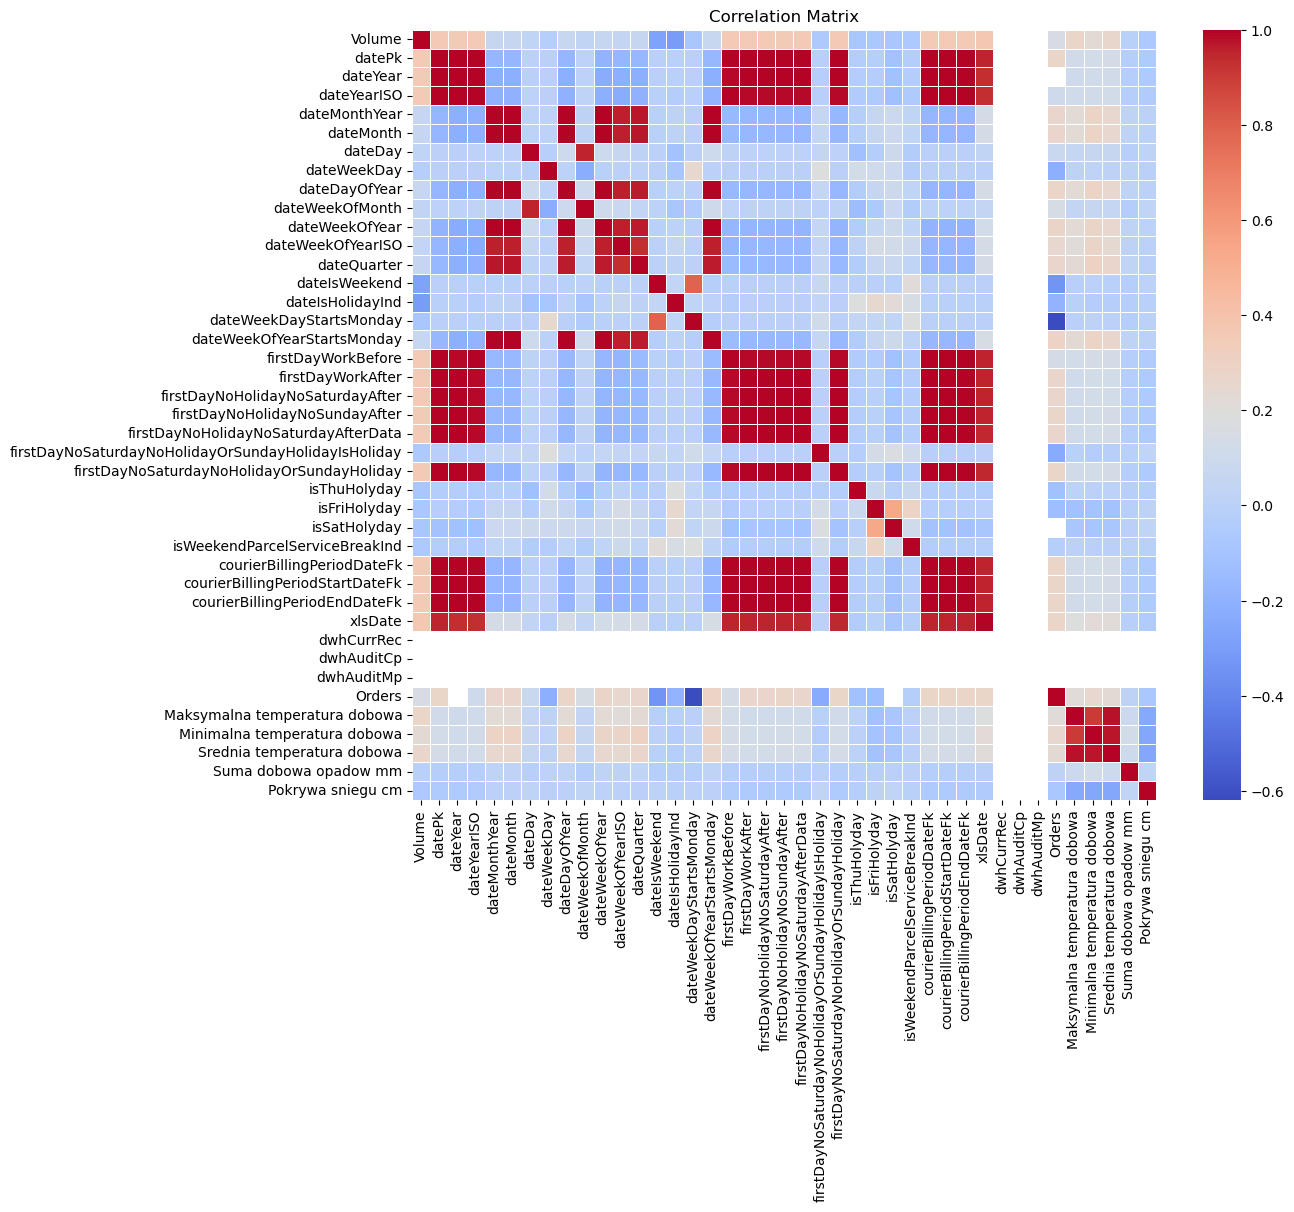

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[num].corr(), cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [19]:
df["dwhCurrRec"].unique(), df["dwhAuditCp"].unique(), df["dwhAuditMp"].unique()

(array([1]), array([1904719]), array([1904719]))

Most features have a **weak linear correlation** or no linear correlation at all with the target value. <br>
The columns `dwhCurrRec`, `dwhAuditCp`, and `dwhAuditMp` have empty values on the chart, because each of them has only one unique value.

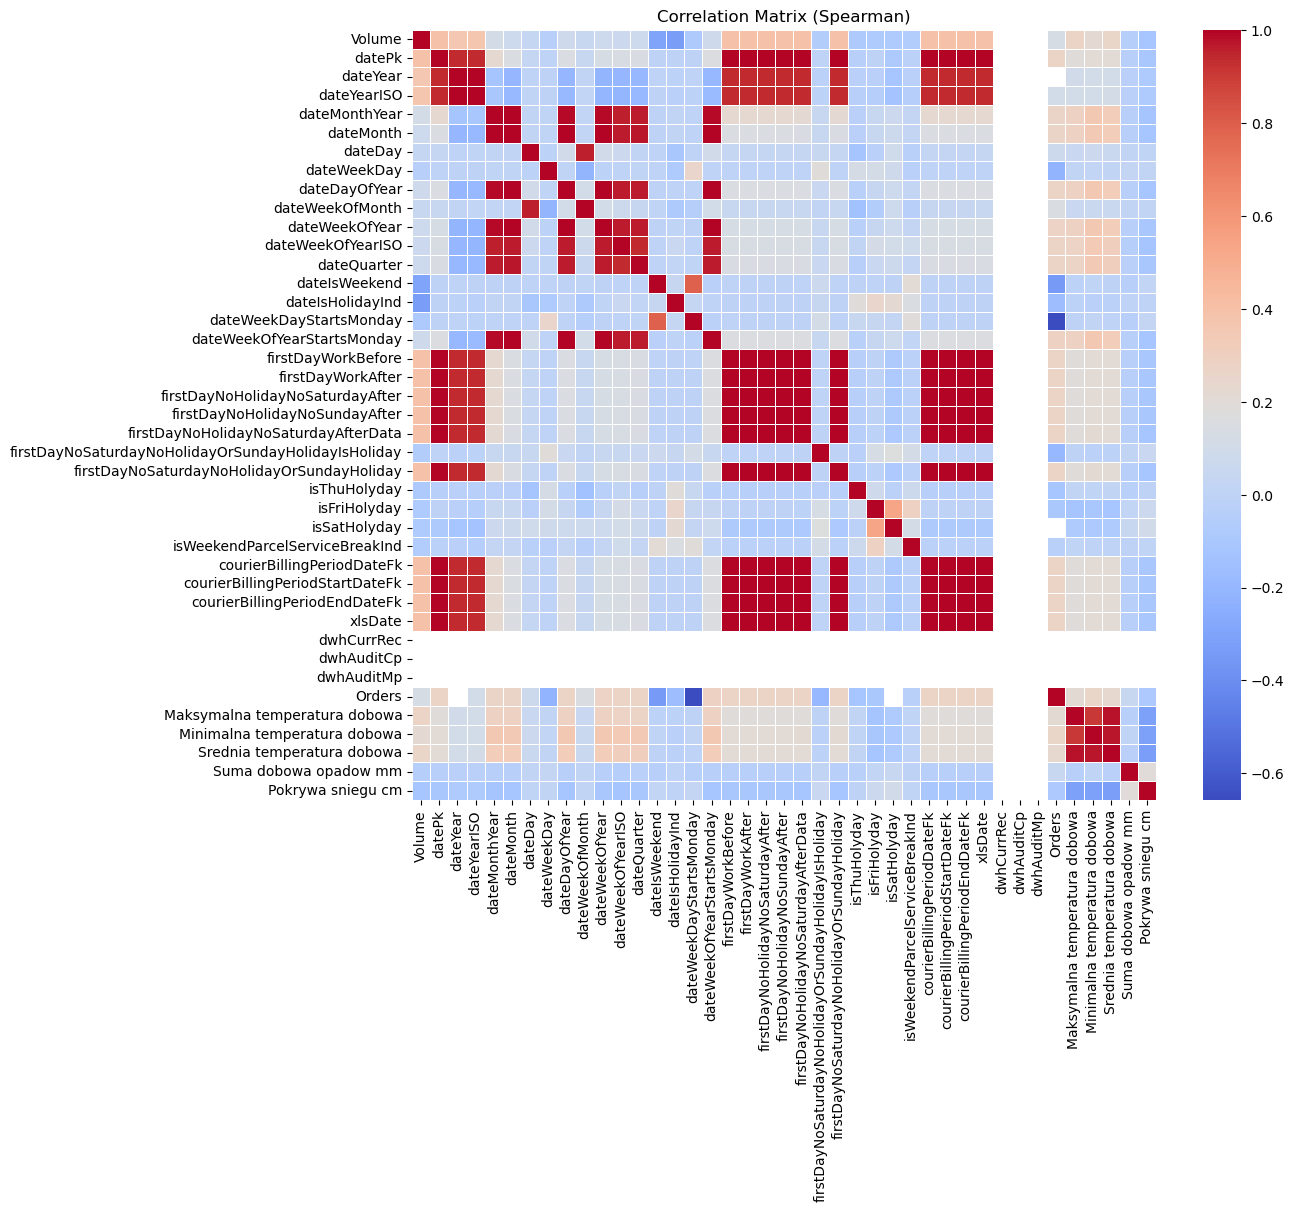

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[num].corr(method="spearman"), cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Spearman)')
plt.show()

Spearman's rank correlation coefficient indicates **stronger** relationships between the target value and the predictors.

In [21]:
print("The features most strongly linearly correlated with the target:")
np.abs(df[num].corr()["Volume"]).sort_values(ascending=False).head(5)

The features most strongly linearly correlated with the target:


Volume                             1.000000
xlsDate                            0.378266
firstDayWorkBefore                 0.360402
courierBillingPeriodEndDateFk      0.355807
courierBillingPeriodStartDateFk    0.355804
Name: Volume, dtype: float64

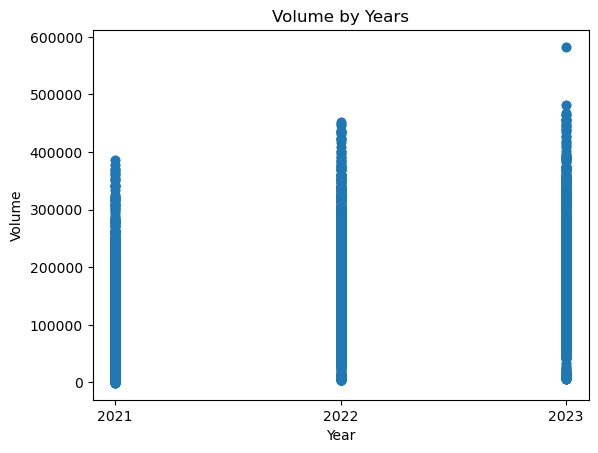

In [22]:
plt.scatter(df["dateYear"], df["Volume"])
plt.xticks(ticks=df['dateYear'].unique())
plt.xlabel("Year")
plt.ylabel("Volume")
plt.title("Volume by Years")
plt.show()

The above chart shows that `Volume` is increasing each Year

## Data preprocessing

In [23]:
num.remove("Volume")

At first, I will split the dataset into training/test sets to avoid data leakage

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Volume", axis = 1), df["Volume"], test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(6227, 62) (1557, 62)


After splitting the dataset into training and test sets with 20% allocated to the test set, the training set consists of 6,227 observations while the test set contains 1,557 observations.

In [43]:
print("Number of NaN values in X_train:", X_train.isna().sum().sum(), "\nNumber of NaN values in X_test:", X_test.isna().sum().sum())

Number of NaN values in X_train: 0 
Number of NaN values in X_test: 0


There are **5,848 NaN** values, all located in the `Orders` column since data for this column has been collected only after January 2023. <br>
I can't remove these rows as they constitute the majority of the DataFrame, so I will impute these missing values instead.

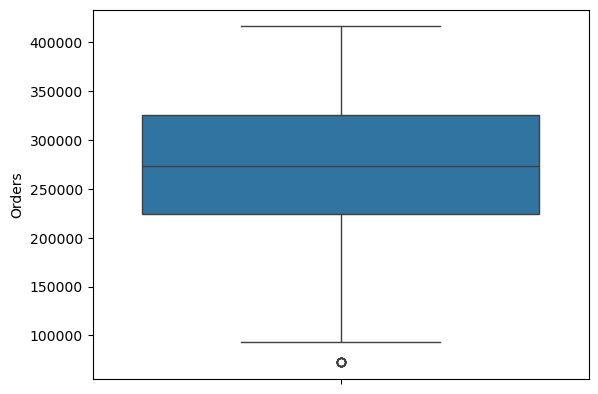

In [26]:
sns.boxplot(df.Orders.dropna())
plt.show()

There are **outliers** in the `Orders` variable

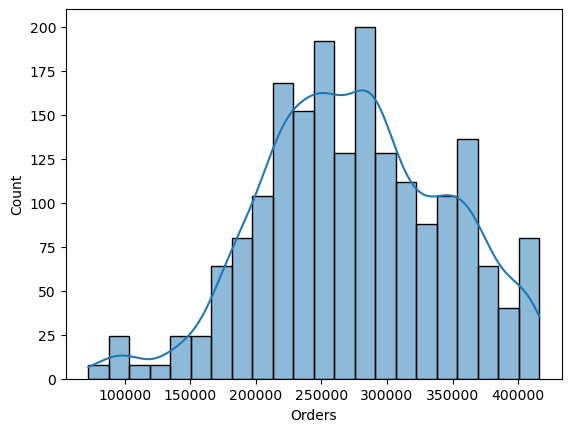

In [27]:
sns.histplot(df.Orders.dropna(), kde=True)
plt.show()

The distribution of the variable is closely similar to the **Normal distribution**

In [28]:
print("The skewness value:", skew(df.Orders.dropna()))

The skewness value: -0.10398471281105137


The skewness value indicates slightly left skew. I prefer using the **KNN algorithm** to impute the NaN values.

In [29]:
imputer = KNNImputer(n_neighbors=3)
X_train[num] = imputer.fit_transform(X_train[num])
X_test[num] = imputer.transform(X_test[num])

In [30]:
print("Number of NaN values in X_train:", X_train.isna().sum().sum(), "\nNumber of NaN values in X_test:", X_test.isna().sum().sum())

Number of NaN values in X_train: 0 
Number of NaN values in X_test: 0


In [31]:
df.describe()

,Volume,date,datePk,dateYear,dateYearISO,dateMonthYear,dateMonth,dateDay,dateWeekDay,dateDayOfYear,...,xlsDate,dwhCurrRec,dwhAuditCp,dwhAuditMp,Orders,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow mm,Pokrywa sniegu cm
count,7784.000000,7784,7.784000e+03,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000,...,7784.000000,7784.0,7784.0,7784.0,1936.000000,7784.000000,7784.000000,7784.000000,7784.000000,7784.000000
mean,143536.470533,2022-05-02 00:00:00.000000256,2.021936e+07,2021.874615,2021.868448,6.228909,6.026721,15.716341,4.000000,167.765673,...,44683.000000,1.0,1904719.0,1904719.0,275094.376827,14.826310,6.286948,10.062384,1.078263,0.345838
min,-876.759667,2021-01-01 00:00:00,2.021010e+07,2021.000000,2020.000000,1.202100,1.000000,1.000000,1.000000,1.000000,...,44197.000000,1.0,1904719.0,1904719.0,72473.494555,-12.800000,-17.500000,-15.700000,0.000000,0.000000
25%,80150.606161,2021-09-01 00:00:00,2.021090e+07,2021.000000,2021.000000,3.202300,3.000000,8.000000,2.000000,82.000000,...,44440.000000,1.0,1904719.0,1904719.0,224440.172888,6.700000,0.400000,3.100000,0.000000,0.000000
50%,130202.764469,2022-05-02 00:00:00,2.022050e+07,2022.000000,2022.000000,6.202200,6.000000,16.000000,4.000000,163.000000,...,44683.000000,1.0,1904719.0,1904719.0,273695.994969,15.400000,6.100000,10.000000,0.000000,0.000000
75%,193735.702340,2022-12-31 00:00:00,2.022123e+07,2022.000000,2022.000000,9.202100,9.000000,23.000000,6.000000,244.000000,...,44926.000000,1.0,1904719.0,1904719.0,325661.470479,22.800000,12.500000,17.200000,0.000000,0.000000
max,582617.649973,2023-08-31 00:00:00,2.023083e+07,2023.000000,2023.000000,12.202200,12.000000,31.000000,7.000000,365.000000,...,45169.000000,1.0,1904719.0,1904719.0,416068.107760,36.700000,21.900000,28.200000,103.400000,27.000000
std,87918.250569,NaN,7.740076e+03,0.780531,0.786080,3.314388,3.314405,8.795459,2.000128,101.275771,...,280.898802,0.0,0.0,0.0,69930.966608,9.659122,7.419088,8.284276,4.160206,2.033543


In [32]:
scaler = MinMaxScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

I scaled the dataset with MinMaxScaler() because the variables have different ranges.

In [33]:
X_train = pd.concat([X_train[num], pd.get_dummies(X_train[categ])], axis=1)
X_test = pd.concat([X_test[num], pd.get_dummies(X_test[categ])], axis=1)

Also, I encoded category variables to build predictive models

## Modeling

I will develop and evaluate 4 machine learning regression models — **Linear Regression**, **Support Vector Regression**, **Random Forest Regression**, and **XGBoost Regression** — to forecast the target variable and compare their performance to determine the best-performing model based on evaluation metrics.

In [34]:
tic = time.time()
mod_lr = LinearRegression()
mod_lr.fit(X_train,y_train)
pred_lr = mod_lr.predict(X_test)
toc = time.time()

print("Linear Regression:")
print(f"R^2: {r2_score(y_test, pred_lr)}, RMSE: {np.sqrt(mean_squared_error(y_test, pred_lr))}, MAE: {mean_absolute_error(y_test, pred_lr)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Linear Regression:
R^2: 0.832729746943029, RMSE: 35335.207427442954, MAE: 27075.023964515418
Modeling time: 0.08 s


In [35]:
tic = time.time()
mod_svr = SVR()
mod_svr.fit(X_train,y_train)
pred_svr = mod_svr.predict(X_test)
toc = time.time()

print("Support Vector Machine Regression:")
print(f"R^2: {r2_score(y_test, pred_svr)}, RMSE: {np.sqrt(mean_squared_error(y_test, pred_svr))}, MAE: {mean_absolute_error(y_test, pred_svr)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Support Vector Machine Regression:
R^2: -0.018305192602837694, RMSE: 87184.09570430077, MAE: 67230.46194439102
Modeling time: 7.27 s


In [36]:
tic = time.time()
mod_rf = RandomForestRegressor(random_state=0)
mod_rf.fit(X_train,y_train)
pred_rf = mod_rf.predict(X_test)
toc = time.time()

print("Random Forest Regression:")
print(f"R^2: {r2_score(y_test, pred_rf)}, RMSE: {np.sqrt(mean_squared_error(y_test, pred_rf))}, MAE: {mean_absolute_error(y_test, pred_rf)}")
print("Modeling time:", np.round(toc-tic,2), "s")

Random Forest Regression:
R^2: 0.9450220183985054, RMSE: 20257.818881274758, MAE: 13255.108646549776
Modeling time: 7.97 s


In [37]:
tic = time.time()
mod_xgb = xgb.XGBRegressor()
mod_xgb.fit(X_train, y_train)
pred_xgb = mod_xgb.predict(X_test)
toc = time.time()

print("XGBoost Regression:")
print(f"R^2: {r2_score(y_test, pred_xgb)}, RMSE: {np.sqrt(mean_squared_error(y_test, pred_xgb))}, MAE: {mean_absolute_error(y_test, pred_xgb)}")
print("Modeling time:", np.round(toc-tic,2), "s")

XGBoost Regression:
R^2: 0.9616008892872308, RMSE: 16930.074586965166, MAE: 12165.117021587708
Modeling time: 0.3 s


XGBoost Regression:
R^2: 0.9616008892872308, RMSE: 16930.074586965166, MAE: 12165.117021587708
Modeling time: 0.37 s

In [38]:
df_scores = pd.DataFrame({"R^2":[r2_score(y_test, pred_lr), 
                                      r2_score(y_test, pred_svr),
                                      r2_score(y_test, pred_rf),
                                      r2_score(y_test, pred_xgb)],
                            "RMSE": [np.sqrt(mean_squared_error(y_test, pred_lr)),
                                    np.sqrt(mean_squared_error(y_test, pred_svr)),
                                    np.sqrt(mean_squared_error(y_test, pred_rf)),
                                    np.sqrt(mean_squared_error(y_test, pred_xgb))],
                            "MAE": [mean_absolute_error(y_test, pred_lr),
                                    mean_absolute_error(y_test, pred_svr),
                                    mean_absolute_error(y_test, pred_rf),
                                    mean_absolute_error(y_test, pred_xgb)]}, index=["LinearRegression", "SVR", "RandomForest", "XGBoost"])
df_scores.sort_values(by='RMSE', ascending=True)

,R^2,RMSE,MAE
XGBoost,0.961601,16930.074587,12165.117022
RandomForest,0.945022,20257.818881,13255.108647
LinearRegression,0.832730,35335.207427,27075.023965
SVR,-0.018305,87184.095704,67230.461944


The **XGBoost** algorithm has the highest scores and is the fastest among the other algorithms. <br>Therefore, let's choose the best  its parameters to further improve its performance.

## Hyperparameter optimization

I used **GridSearchCV** to find the best parameters for the **XGBoost** model on this dataset. <br> 
To reduce the compilation time, I selected just 5 parameters, but additional parameters can be explored for further refinement.

`P.S. If you have the XGBoost library with GPU acceleration support, you can uncomment line #13 to speed up the compilation process. This will allow you to include more parameters and increase the number of cross-validation folds.`

In [39]:
import warnings
warnings.filterwarnings('ignore', module='joblib')

params = {
    'n_estimators': [400, 500],
    'learning_rate': [0.3, 0.5],
    'max_depth':  [7, 8],
    'reg_lambda': [500, 1000],
    'reg_alpha': [500, 1000]
}

mod_xgb = xgb.XGBRegressor()
#mod_xgb = xgb.XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor')

gs = GridSearchCV(estimator=mod_xgb, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
print(f"Best parameters: {gs.best_params_} \nBest cross-validation score: {np.sqrt(-gs.best_score_)} (RMSE)")

best_xgb_model = gs.best_estimator_
pred_best_xgb = best_xgb_model.predict(X_test)
y_train_pred = best_xgb_model.predict(X_train)

print("-"*50)
print("Test scores")
print(f"R^2: {r2_score(y_test, pred_best_xgb)}, RMSE: {np.sqrt(mean_squared_error(y_test, pred_best_xgb))}, MAE: {mean_absolute_error(y_test, pred_best_xgb)}")
print("-"*50)
print("Training scores")
print(f"R^2: {r2_score(y_train, y_train_pred)}, RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}, MAE: {mean_absolute_error(y_train, y_train_pred)}")


Best parameters: {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 500, 'reg_alpha': 500, 'reg_lambda': 500} 
Best cross-validation score: 13222.017303702516 (RMSE)
--------------------------------------------------
Test scores
R^2: 0.9788560462808926, RMSE: 12562.942958440892, MAE: 8983.760298043146
--------------------------------------------------
Training scores
R^2: 0.9970789620127418, RMSE: 4771.589580710405, MAE: 3597.779657201075


After hyperparameter tuning, the optimized predictive model achieved high scores, accurately explaining **98%** of the variance in the test data

In [40]:
df["Volume"].describe()

count      7784.000000
mean     143536.470533
std       87918.250569
min        -876.759667
25%       80150.606161
50%      130202.764469
75%      193735.702340
max      582617.649973
Name: Volume, dtype: float64

The RMSE and MAE values are relatively low compared to the target's mean and standard deviation

In [41]:
cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
print(f"Cross-Validation Score: {np.sqrt(-cv_scores.mean())} (RMSE)")

Cross-Validation Score: 13222.017303702516 (RMSE)


Cross-validation score indicates good generalization. <br>
However, the gap between training and cross-validation RMSE suggests that the model might be slightly overfitted

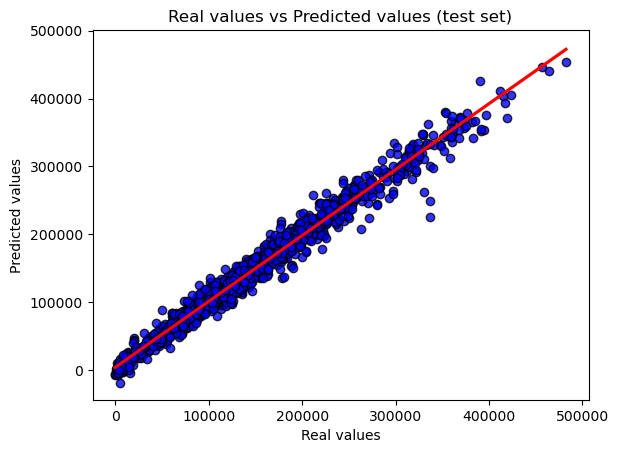

In [42]:
sns.regplot(x = y_test, y=pred_best_xgb, scatter_kws={'color': 'blue', 'edgecolor': 'k'}, line_kws={'color': 'red', 'linestyle': 'solid'})
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Real values vs Predicted values (test set)")
plt.show()

## Conclusion

After analyzing and merging the datasets, I built machine learning models to predict the number of transmissions. The XGBoost model achieved the best performance with the following results after hyperparameter tuning:

- **R² Score:** 0.98
- **Root Mean Squared Error (RMSE):** 12563
- **Mean Absolute Error (MAE):** 8984
- **Cross-Validation Score (RMSE):** 13222

These results demonstrate that the model accurately predicts transmissions, explaining about 98% of the variance with minimal error. The RMSE and MAE values are relatively low compared with the target range. <br>
The model is slightly overfitted because the gap between training and testing is big, but it can be fixed with regularization or feature selection.

##### Suggestions for further improving the model:
- Feature Engineering / Selection
- GPU acceleration
- Better hyperparameter tuning 

Overall, the **XGBoost model** provides a robust and reliable solution for forecasting future transmissions. 

## Thanks for reading!